In [1]:
# PROJECT HEADER 
# Project: Car Fuel Consumption Prediction
# Goal: Predict fuel consumption based on vehicle features to optimize fleet management.
# Author: Marek Hoyler
# Date: Juni 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Set plotting style for better visuals
sns.set(style="whitegrid")

In [2]:
#DATA LOADING and TRANSLATION
# Load the dataset (Ensure 'data.csv' is in the same folder)
from pathlib import Path
# Load the dataset
df = pd.read_csv('data.csv')


# Show first rows BEFORE renaming columns (requested)
print(df.head())

# Rename columns from German to English for consistency
df.rename(columns={
    'fahrzeug_id': 'vehicle_id',
    'typ': 'type',
    'kilometerstand': 'mileage',
    'laenge': 'length',
    'hoehe': 'height',
    'gewicht': 'weight',
    'sitze': 'seats',
    'farbe': 'color',
    'ps': 'horsepower',
    'schaltung': 'transmission',
    'verbrauch': 'consumption',
    'neupreis': 'price_new',
    'gebrauchtpreis': 'price_used',
    'erstzulassung': 'registration_date'
}, inplace=True)

# Display the first few rows to verify changes
df.head()

   fahrzeug_id           typ  kilometerstand  laenge  hoehe  gewicht  sitze  \
0            1  Kompactwagen       44356.620    4.80   1.66     1225      5   
1            2  Kompaktwagen       52881.994    4.57   1.57     1997      4   
2            3  Kompaktwagen       47186.434    4.19   1.62     1922      4   
3            4  Kompaktwagen       66566.266    4.37   1.36     1659      4   
4            5  Kompaktwagen       45336.801    4.37   1.56     1900      4   

     farbe   ps      schaltung  verbrauch  neupreis  gebrauchtpreis  \
0     gelb  120  Handschaltung       5.30  69400.96        39406.15   
1  schwarz  171  Handschaltung       8.45  40441.14        22737.53   
2     grau  161      Automatik       7.93  38245.55        21890.94   
3     gelb  182      Automatik       5.88  38662.15        18563.32   
4     gelb  181      Automatik       7.87  30981.58        14703.85   

  erstzulassung  
0    2022-04-13  
1    2023-03-16  
2    2023-03-27  
3    2022-06-12  
4    202

,vehicle_id,type,mileage,length,height,weight,seats,color,horsepower,transmission,consumption,price_new,price_used,registration_date
0,1,Kompactwagen,44356.620,4.80,1.66,1225,5,gelb,120,Handschaltung,5.30,69400.96,39406.15,2022-04-13
1,2,Kompaktwagen,52881.994,4.57,1.57,1997,4,schwarz,171,Handschaltung,8.45,40441.14,22737.53,2023-03-16
2,3,Kompaktwagen,47186.434,4.19,1.62,1922,4,grau,161,Automatik,7.93,38245.55,21890.94,2023-03-27
3,4,Kompaktwagen,66566.266,4.37,1.36,1659,4,gelb,182,Automatik,5.88,38662.15,18563.32,2022-06-12
4,5,Kompaktwagen,45336.801,4.37,1.56,1900,4,gelb,181,Automatik,7.87,30981.58,14703.85,2022-11-20


In [3]:
#FEATURE ENGINEERING

# Calculate 'Car Age' from 'registration_date'
# Convert registration_date to datetime objects first
df['registration_date'] = pd.to_datetime(df['registration_date'], errors='coerce')

# Calculate age: Current Year - Registration Year
current_year = datetime.now().year
df['car_age'] = current_year - df['registration_date'].dt.year

# Check for new column
print("Feature Engineering complete. 'car_age' created.")
df[['registration_date', 'car_age']].head()

Feature Engineering complete. 'car_age' created.


,registration_date,car_age
0,2022-04-13,3
1,2023-03-16,2
2,2023-03-27,2
3,2022-06-12,3
4,2022-11-20,3



Missing values in the dataset:
vehicle_id           0
type                 0
mileage              0
length               0
height               0
weight               0
seats                0
color                0
horsepower           0
transmission         0
consumption          0
price_new            0
price_used           0
registration_date    0
car_age              0
dtype: int64


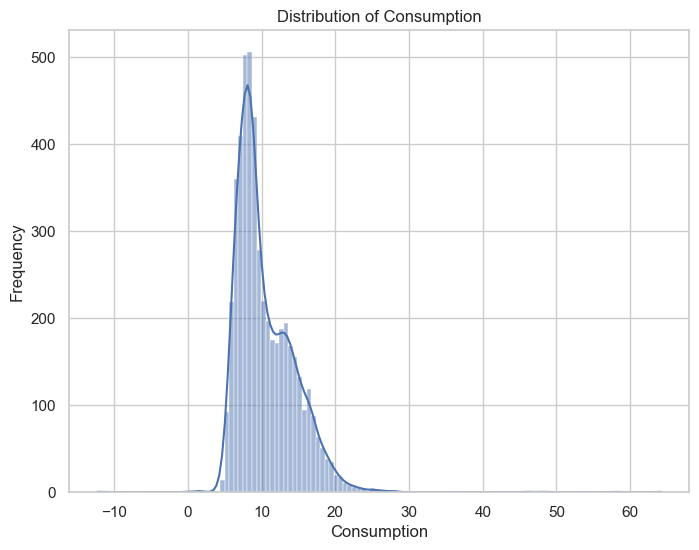

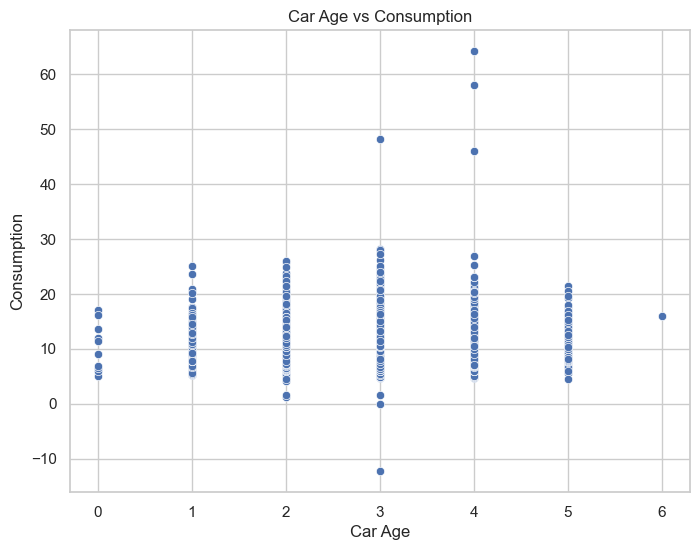

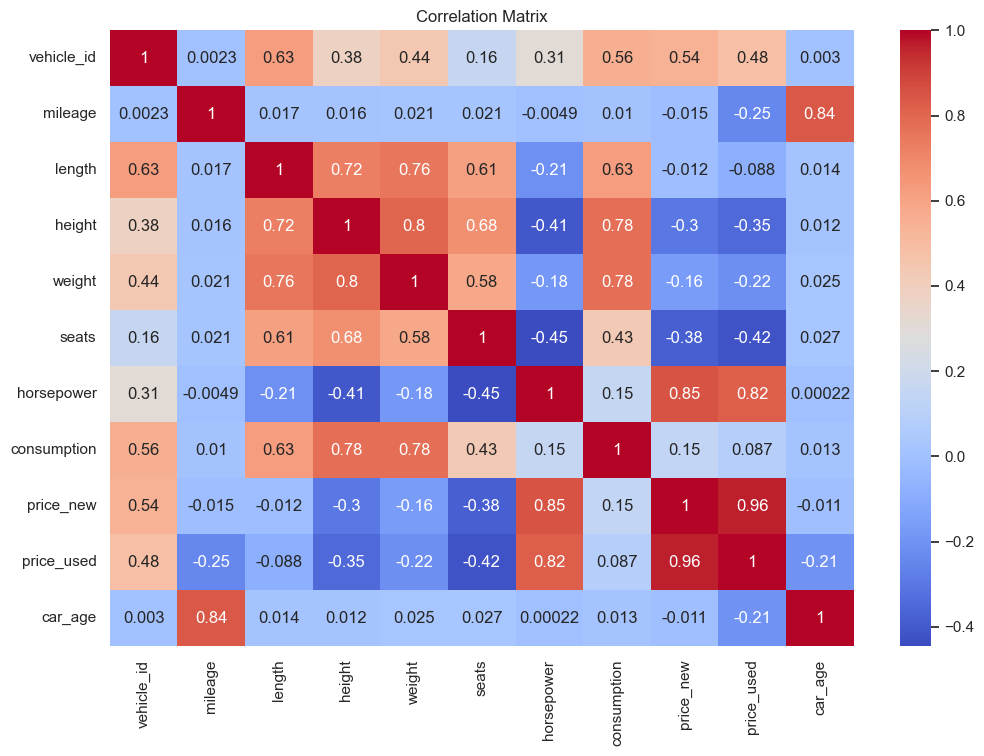

In [4]:
# Exploratory Data Analysis
# Display basic statistics of the dataset
# print("Basic statistics of the dataset:")
# print(df.describe())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Visualize the distribution of the target variable 'consumption'
plt.figure(figsize=(8, 6))
sns.histplot(df['consumption'], kde=True)
plt.title('Distribution of Consumption')
plt.xlabel('Consumption')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between features and the target variable
# For example, car_age vs consumption
plt.figure(figsize=(8, 6))
sns.scatterplot(x='car_age', y='consumption', data=df)
plt.title('Car Age vs Consumption')
plt.xlabel('Car Age')
plt.ylabel('Consumption')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
#Cleaning
# Remove negative or zero consumption (Physical impossibility)
# We also remove extremely high outliers (e.g., > 25 liters) to help the model generalize
print("Rows before cleaning:", len(df))

# Filter Consumption: Keep only values between 1 and 25 liters
df = df[(df['consumption'] > 1) & (df['consumption'] < 25)]

# Investigate and Fix Car Age
# If all cars are 55 years old, the column is useless.
# Check if we have varying ages:
print("Unique Car Ages:", df['car_age'].unique())

# because it contains no useful information.
if df['car_age'].nunique() < 2:
    print("Dropping car_age because it has no variance (all values are the same).")
    df.drop(columns=['car_age'], inplace=True)
# Otherwise, filter out the erroneous '55' year olds if there are valid other ages
else:
    df = df[df['car_age'] < 50] 

print("Rows after cleaning:", len(df))

Rows before cleaning: 5000
Unique Car Ages: [3 2 4 1 0 5 6]
Rows after cleaning: 4984


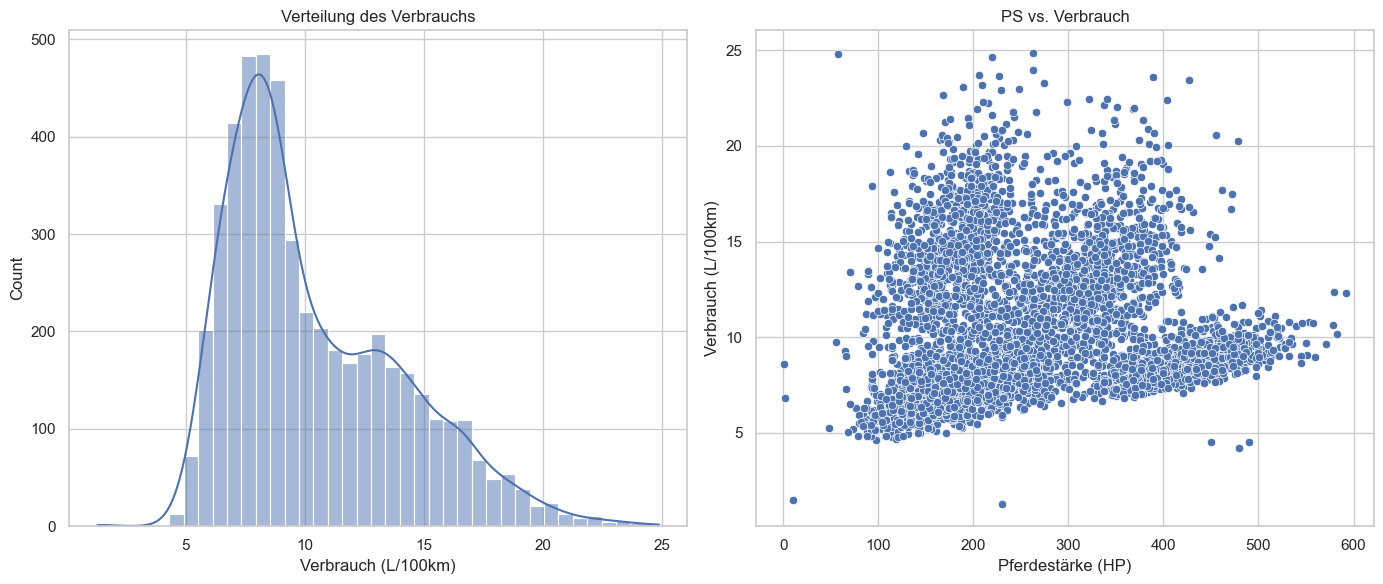

In [ ]:
plt.figure(figsize=(14, 6))

# 1. Distribution of Consumption
plt.subplot(1, 2, 1)
sns.histplot(df['consumption'], kde=True)
plt.title('Distribution of Consumption')
plt.xlabel('Consumption (L/100km)')

# 2. Scatter Plot (Horsepower vs. Consumption)
plt.subplot(1, 2, 2)
sns.scatterplot(x='horsepower', y='consumption', data=df)
plt.title('Horsepower vs. Consumption')
plt.xlabel('Horsepower (HP)')
plt.ylabel('Consumption (L/100km)')

plt.tight_layout()
plt.show()

In [10]:
#DATA PREPARATION FOR MODELING

# Encode categorical columns (e.g., Color, Transmission) into numbers
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Define Features (X) and Target (y)
# We exclude 'consumption' (target) and 'registration_date' (not needed for model)
drop_cols = ['consumption', 'registration_date','vehicle_id']
# Ensure we don't try to drop columns that might already be gone
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['consumption']

# Split into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 3987 samples
Testing set size: 997 samples



## Model Selection Rationale

Based on the exploratory data analysis, we are trying to predict a continuous variable ('consumption'). This is a regression problem.

Several models could be suitable for this task:

1.  **Linear Regression**: This is a good starting point as it's simple to implement and interpret. It assumes a linear relationship between the features and the target. If the EDA suggests linear relationships (e.g., scatter plots, correlation matrix), this could be a viable model.

2.  **Polynomial Regression**: If the relationship between features and the target is non-linear, polynomial regression can capture this. It's an extension of linear regression.

3.  **Decision Tree Regressor**: This model is non-parametric and can capture complex non-linear relationships. It's also robust to outliers and doesn't require feature scaling. However, single decision trees can be prone to overfitting.

4.  **Random Forest Regressor**: This is an ensemble model that builds multiple decision trees and averages their predictions. It generally performs better than a single decision tree, is less prone to overfitting, and can handle a large number of features. It's a strong candidate for this problem.

5.  **Gradient Boosting Regressor (e.g., XGBoost, LightGBM, CatBoost)**: These are also ensemble models that build trees sequentially, where each new tree corrects the errors of the previous ones. They often provide state-of-the-art results on many regression tasks but can be more complex to tune.

**Chosen Model: Random Forest Regressor**

*   **Robustness**: Random Forests are generally robust to outliers and non-linear data.
*   **Performance**: They often provide good predictive accuracy without extensive hyperparameter tuning.
*   **Feature Importance**: They can provide insights into which features are most important for the prediction.
*   **Handles Mixed Data Types**: Can handle numerical and categorical features (though we might need to encode categorical ones).

Given the nature of the data (car features potentially having non-linear impacts on consumption), a Random Forest Regressor is a solid choice. We will start with this and can explore other models like Gradient Boosting if further improvements are needed.


Training Random Forest Regressor...
Model training complete.
------------------------------
Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0787
Root Mean Squared Error (RMSE): 0.2806
R-squared (R2 Score): 0.9934
Out-of-Bag (OOB) Score: 0.9792
------------------------------

Top 5 Important Features:
        feature  importance
3        height    0.829641
7    horsepower    0.136211
8  transmission    0.013839
4        weight    0.009669
0          type    0.002549


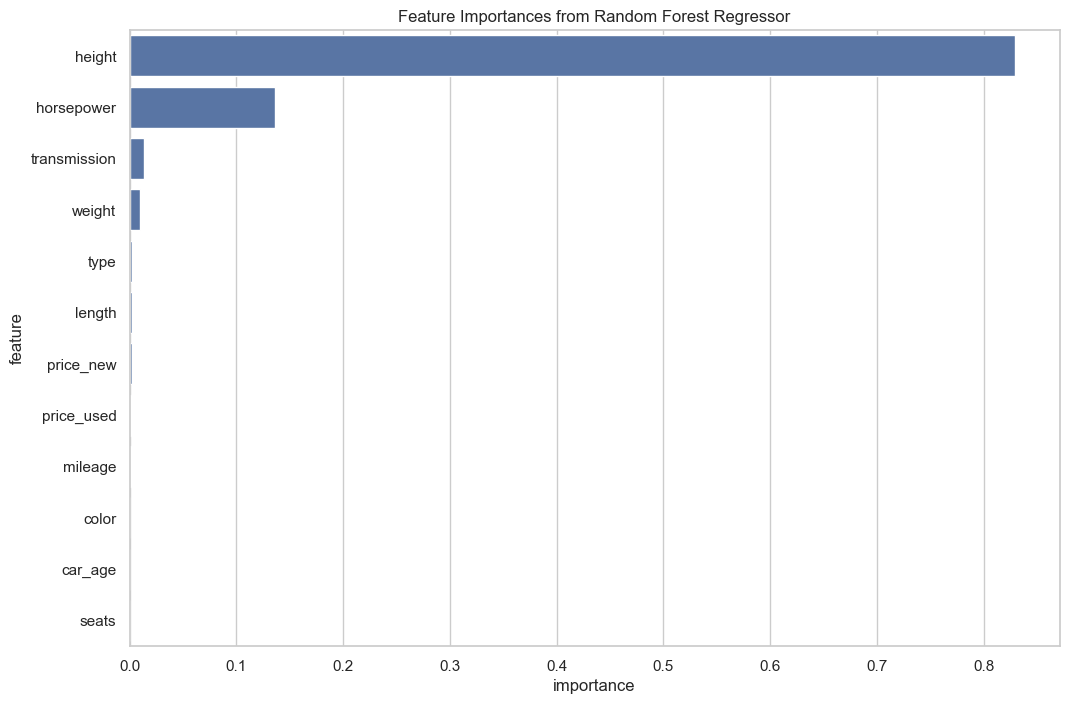


Analysis complete. The Random Forest model has been trained and evaluated.


In [8]:
#MODEL TRAINING

# Initialize the Random Forest Regressor
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

# Train the model
rf_model.fit(X_train, y_train)
print("Model training complete.")

# MODEL EVALUATION

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)
oob = rf_model.oob_score_ 

print("-" * 30)
print(f"Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")
print(f"Out-of-Bag (OOB) Score: {oob:.4f}")
print("-" * 30)

#FEATURE IMPORTANCE

importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 5 Important Features:")
print(feature_importance_df.head())

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest Regressor')
plt.show()

# Final Conclusion
print("\nAnalysis complete. The Random Forest model has been trained and evaluated.")